In [1]:
import numpy as np
import pwlf
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
input_file = "input_file/phpunit.csv" #Input data 
min_s = 2 #min segements 
max_s = 15 #max segements 

In [3]:
df_composer = pd.read_csv(input_file)
# Prepare the data for pwlf
x = df_composer['accumulative_raw'].values
y = df_composer['complexity_raw'].values

### fit model and return the metrics

In [4]:
def fit_model(X, Y, m, cv_splits=5, random_state=42, is_fast=False):
    """拟合 m 段并计算各类指标"""
    mdl = pwlf.PiecewiseLinFit(X, Y)
    if is_fast == False:
        breaks = mdl.fit(m) 
    else: 
        breaks = mdl.fastfit(m) 
    y_hat = mdl.predict(X)

    n   = len(Y)
    rss = float(np.sum((Y - y_hat)**2))
    mse = rss / n 
    mae = float(mean_absolute_error(Y, y_hat)) #Mean Absolut Error 
    tss = float(np.sum((Y - np.mean(Y))**2)) #Total Sum of Squares, TSS
    r2  = 1 - rss / tss if tss > 0 else np.nan

    # 参数个数惩罚：常用近似 k = 2*m（斜率/截距 + 断点自由度）
    k   = 2 * m
    aic = n * np.log(mse) + 2 * k #在保证模型拟合数据的同时，尽量避免模型过于复杂（overfitting）。
    bic = n * np.log(mse) + k * np.log(n) #在拟合效果和模型复杂度之间做权衡，但 比 AIC 惩罚更严格。
    r2_adj = 1 - ((rss/(n - k)) / (tss/(n - 1))) if (n - k) > 0 and (tss > 0) else np.nan

#     # 交叉验证 MSE
#     kf = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
#     cv_mses = []
#     for tr, te in kf.split(X):
#         Xtr, Ytr = X[tr], Y[tr]
#         Xte, Yte = X[te], Y[te]
#         mdl_cv = pwlf.PiecewiseLinFit(Xtr, Ytr)
#         mdl_cv.fit(m)
#         Ypred = mdl_cv.predict(Xte)
#         cv_mses.append(mean_squared_error(Yte, Ypred))
#     cv_mse = float(np.mean(cv_mses))

    return {
        "m": m,
        "breaks": breaks,
        "train_MSE": mse,
        "train_MAE": mae,
        "R2": r2,
        "R2_adj": r2_adj,
        "AIC": aic,
        "BIC": bic,
#         "CV_MSE": cv_mse,
    }

### Evaluate the segments have the best metrics

In [5]:
def evaluate_all_segments(X, Y, min_m=2, max_m=40, criterion="BIC",
                          cv_splits=5, random_state=42, early_stop=True, is_fast=False):
    """
    遍历分段数，返回每个 m 的指标，并根据 criterion 选最佳。
    criterion ∈ {"BIC","AIC","CV_MSE","R2_adj","MSE"}
      - MSE 越小越好（MSE 指训练集 MSE，对应键为 'train_MSE'）
      - R2_adj 越大越好
    """
    X = np.asarray(X).reshape(-1)
    Y = np.asarray(Y).reshape(-1)
    n = len(Y)

    # 基本可行性限制：至少保证每段有≥2个点（保守些）
    max_feasible = max(min(max_m, n // 2), min_m)
    ms = list(range(min_m, max_feasible + 1))

    crit = criterion.upper()
    # 将 "MSE" 统一映射到结果 dict 中的键名
    metric_key = {"MSE": "train_MSE"}.get(crit, crit)

    results = []
    for m in ms:
        t0 = time.perf_counter()
        try:
            res = fit_model(X, Y, m, cv_splits=cv_splits, random_state=random_state, is_fast=is_fast)
            t1 = time.perf_counter()
            res["time_s"] = t1 - t0
            results.append(res)
            
        except Exception as e:
            t1 = time.perf_counter()
            # 若某些 m 因数据分布问题无法拟合，记录错误并继续
            results.append({"m": m, "error": str(e), "time_s": float(t1 - t0)})

        # 提前停止逻辑（基于所选 criterion）
        if early_stop and len(results) >= 3:
            last_three = [r for r in results[-3:] if "error" not in r and metric_key in r]
            if len(last_three) == 3:
                v0, v1, v2 = [r[metric_key] for r in last_three]
                if crit in ("MSE"):
                    # 越小越好：若連續三次指標遞增，說明開始惡化，停止
                    if (v2 > v1) and (v1 > v0):
                        break
                elif crit == "R2_ADJ":
                    # 越大越好：若连续三次指标递减，停止
                    if (v2 < v1) and (v1 < v0):
                        break

    # 选最优
    valid = [r for r in results if "error" not in r]
    if not valid:
        raise RuntimeError("没有成功的拟合结果，请检查数据或放宽可行范围。")

    if crit in ("MSE"):
        # 越小越好；NaN/缺失时丢到 +∞
        def safe_val(r):
            v = r.get(metric_key, np.inf)
            return v if (v is not None and not np.isnan(v)) else np.inf
        best = min(valid, key=safe_val)

    # 打印摘要
    print("=== Summary ===")
    for r in valid:
        print(f"m={r['m']:>2} | "
              f"MSE={r['train_MSE']:.3f} | "
              f"time={r['time_s']:.2f} s | "
              f"breaks={np.round(r['breaks'],3)}"
             
             )
        print("--------------------------")
    shown_key = metric_key 
    print(f"\n✅ Best by {criterion}: Segments(m)={best['m']}, MSE={best[shown_key]:.3f}, time:{best['time_s']:.2f}, breaks={np.round(best['breaks'], 6)}")
    return {"all": results, "best": best}

In [6]:
results = evaluate_all_segments(x, y, min_m=min_s, max_m=max_s, criterion="MSE",is_fast=False)

=== Summary ===
m= 2 | MSE=139252.549 | time=0.02 s | breaks=[1.78752000e+03 5.25808761e+05 3.44799690e+06]
--------------------------
m= 3 | MSE=135268.600 | time=0.11 s | breaks=[1.78752000e+03 9.01090338e+05 1.88571732e+06 3.44799690e+06]
--------------------------
m= 4 | MSE=134310.430 | time=0.27 s | breaks=[1.78752000e+03 8.90136247e+05 2.24965979e+06 2.89239983e+06
 3.44799690e+06]
--------------------------
m= 5 | MSE=133124.674 | time=0.92 s | breaks=[1.78752000e+03 9.98870575e+05 1.00235389e+06 2.24138394e+06
 2.88559245e+06 3.44799690e+06]
--------------------------
m= 6 | MSE=127375.222 | time=9.49 s | breaks=[1.78752000e+03 8.37339627e+05 8.37378774e+05 8.39625189e+05
 2.30367155e+06 2.30407113e+06 3.44799690e+06]
--------------------------
m= 7 | MSE=126230.288 | time=19.04 s | breaks=[1.78752000e+03 8.37206323e+05 8.37345128e+05 8.40084701e+05
 2.21502073e+06 2.21601244e+06 2.31297170e+06 3.44799690e+06]
--------------------------
m= 8 | MSE=125302.128 | time=31.40 s | b

In [7]:
# Extract the "best" result (with chosen m)
best_result = results['best']

# Get the breakpoints array
breakpoints = best_result['breaks']

# print("Breakpoints as array:", breakpoints)
print("Breakpoints as Python list:", breakpoints.tolist())

Breakpoints as Python list: [1787.52, 837265.7799947781, 837452.0266619493, 839683.6791714171, 1120917.4701528167, 2450372.525706181, 2622511.14488965, 2635118.184588444, 2727067.9113702234, 2730117.9520294876, 2842486.4684032802, 3447996.899999999]


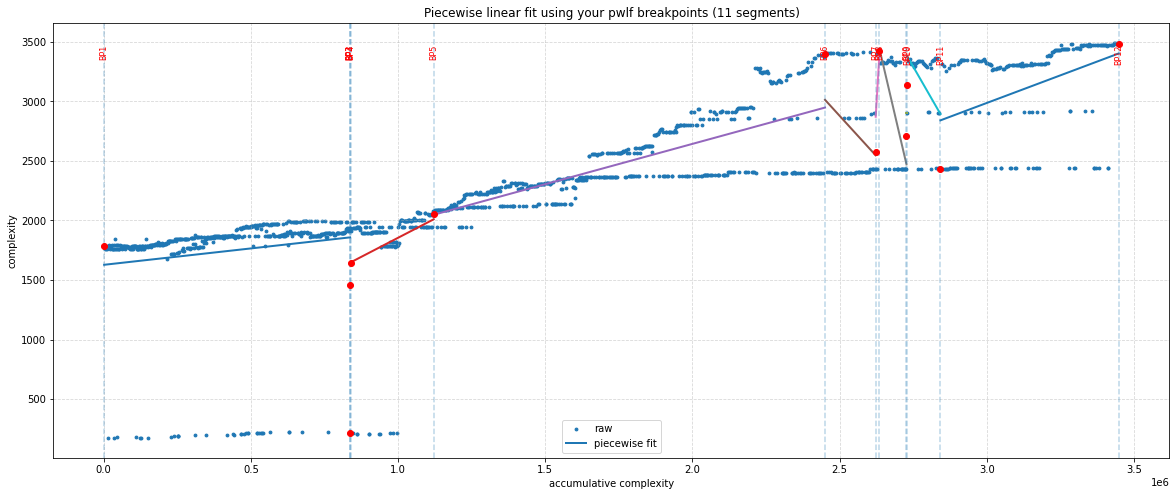

In [8]:
plt.figure(figsize=(20, 8))
plt.scatter(x, y, s=8, label='raw')

requested_segments = len(breakpoints) - 1

for i in range(len(breakpoints) - 1):
    x0, x1 = breakpoints[i], breakpoints[i+1]
    mask = (x >= x0) & ((x < x1) if i < len(breakpoints)-2 else (x <= x1))
    Xi, Yi = x[mask], y[mask]

    if Xi.size >= 2:
        X1 = np.vstack([np.ones_like(Xi), Xi]).T
        beta, *_ = np.linalg.lstsq(X1, Yi, rcond=None)
        a, b = beta
        xs = np.linspace(x0, x1, 200)
        ys = a + b*xs
    elif Xi.size == 1:
        xs = np.linspace(x0, x1, 200)
        ys = np.full_like(xs, Yi.item())
    else:
        xs = np.linspace(x0, x1, 200)
        ys = np.full_like(xs, y.mean())
    
    plt.plot(xs, ys, linewidth=2, label='piecewise fit' if i==0 else None)

# --- draw vertical lines and annotate breakpoints ---
for j, bp in enumerate(breakpoints):
    plt.axvline(bp, linestyle='--', alpha=0.3)
    # mark point on axis
    plt.scatter(bp, np.interp(bp, x, y), color='red', zorder=5)
    # label
    plt.text(bp, plt.ylim()[1]*0.95, f'BP{j+1}', rotation=90,
             va='top', ha='center', fontsize=8, color='red')

plt.title(f'Piecewise linear fit using your pwlf breakpoints ({requested_segments} segments)')
plt.xlabel('accumulative complexity')
plt.ylabel('complexity')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()
